<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/master/examples/tutorials/classifying_MNIST_vit_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>--> 

In [1]:
%matplotlib inline

!pip install deeptrack

## Handwritten Digit Classification using Vision Transformers

Trains a Vision Transformer (ViT) to identify handwritten digits using MNIST dataset.


### 1. Setup
Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt
from deeptrack.extras import datasets

import tensorflow as tf
import tensorflow_addons as tfa

import logging
logging.disable(logging.WARNING)

datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, "training_labels.npy")
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")

MNIST already downloaded! Use force_overwrite=True to redownload the dataset.


### 2. Defining the dataset

#### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`. 

In [3]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)
get_training_labels = dt.LoadImage(path=TRAINING_LABELS_PATH)

get_validation_images = dt.LoadImage(path=VALIDATION_SET_PATH)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

Note that we don't load the images yet, we have just created the objects that will do so. First, we normalize the data.

In [4]:
normalization = dt.NormalizeMinMax(0, 1)

get_training_images >>= normalization
get_validation_images >>= normalization

Since all training data is contained in a single file, we explicitly load the images

In [5]:
training_images = get_training_images.resolve()
training_labels = get_training_labels.resolve()

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

We want to continuously generate new data for the network to train on. For this, we use the `Dataset` feature.

In [6]:
training_data_iterator = itertools.cycle(training_images)
training_label_iterator = itertools.cycle(training_labels)

training_dataset = dt.Dataset(
    data=training_data_iterator, 
    label=training_label_iterator
)

#### 2.3 Defining the target
The training iterator resolves images. We can extract the label that we provided to the Dataset feature by just calling `get_property`.

In [7]:
def get_label(image):
    return np.array(image.get_property("label")).squeeze()

#### 2.4 Visualizing the dataset
To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

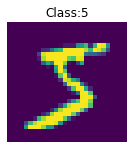

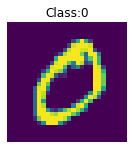

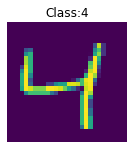

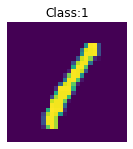

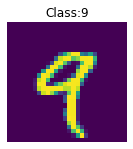

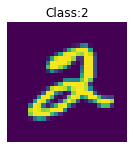

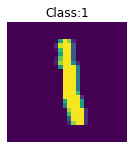

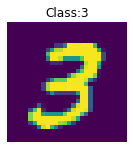

In [8]:
NUMBER_OF_IMAGES = 8

for image_index in range(NUMBER_OF_IMAGES):
    
    image = training_dataset.update()()
    
    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Class:" + str(get_label(image)))
    plt.show()

### 3. Defining the network

The network used is a Vision Transformer. Here we define the network architecture, loss function and the optimizer.

In [9]:
model = dt.models.ViT(
            input_shape=(28, 28, 1),  # Size of the images to be analyzed
            patch_shape=4, # Size of the patches to be extracted from the input images.
            num_layers=4, # Number of Transformer layers in the ViT model.
            hidden_size=72, # Size of the hidden layers in the ViT model
            number_of_heads=12, # Number of attention heads in each Transformer layer
            fwd_mlp_dim=256, # Size of the hidden layers in the forward MLP of the Transformer layers.
            dropout=0.1, # Dropout rate of the forward MLP in the Transformer layers.
            include_top=True, # Whether to include the top layer of the ViT model.
            output_size=10, # Size of the output layer of the ViT model (i.e., the number of classes).
            output_activation="linear", # The activation function of the output.
        )


# compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    metrics=["accuracy"],
)

model.summary() 

AttributeError: module 'deeptrack.models' has no attribute 'ViT'

### 4. Training the network
The network is trained for 100 epochs using standard Keras syntax.

Generating 1001 / 1000 samples before starting training
Epoch 1/100
7/7 [==============================] - 2s 263ms/step - loss: 2.5730 - accuracy: 0.0904 - val_loss: 2.2582 - val_accuracy: 0.1260
Epoch 2/100
7/7 [==============================] - 1s 190ms/step - loss: 2.3235 - accuracy: 0.1328 - val_loss: 2.1832 - val_accuracy: 0.2180
Epoch 3/100
7/7 [==============================] - 2s 332ms/step - loss: 2.2043 - accuracy: 0.1842 - val_loss: 2.0810 - val_accuracy: 0.2520
Epoch 4/100
7/7 [==============================] - 3s 358ms/step - loss: 2.1722 - accuracy: 0.2221 - val_loss: 1.9673 - val_accuracy: 0.3240
Epoch 5/100
7/7 [==============================] - 3s 362ms/step - loss: 2.0488 - accuracy: 0.2567 - val_loss: 1.8099 - val_accuracy: 0.3760
Epoch 6/100
7/7 [==============================] - 1s 102ms/step - loss: 1.9210 - accuracy: 0.3203 - val_loss: 1.6748 - val_accuracy: 0.3960
Epoch 7/100
7/7 [==============================] - 2s 227ms/step - loss: 1.7685 - accuracy: 0.3616

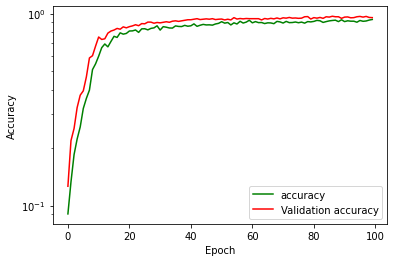

In [ ]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        training_dataset & (training_dataset >> get_label),
        batch_size=128,
        min_data_size=1000,
        max_data_size=1001,
    )
    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.expand_dims(validation_images[:500], -1),
                validation_labels[:500].squeeze() 
            ),
            epochs=100
        )
    
    plt.plot(h.history["accuracy"], 'g')
    plt.plot(h.history["val_accuracy"], 'r')
    plt.legend(["accuracy", "Validation accuracy"])
    plt.yscale("log")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    

### 5. Evaluating the network

The attention maps learned by the network are visualized for intepretation.

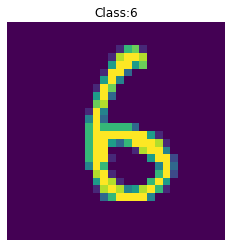

In [ ]:
# index of validation image
idx = 3000

image = validation_images[idx]
prediction = np.argmax(
    model.predict(
        np.expand_dims(image, (0, -1))
    )
)

plt.imshow(image)
plt.axis('off')
plt.title("Class:" + str(prediction))
plt.show()

We extract the attention scores from the transformer blocks

In [ ]:
outputs = [
        l.output[1]
        for l in model.layers
        if isinstance(l, dt.models.TransformerEncoder)
    ]

weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(
            np.expand_dims(image, (0, -1))
        )
    )

# retain the output of the last transformer layer
weights = np.squeeze(weights, 1)[-1]

In [ ]:
from skimage.transform import resize

# Number of heads
num_heads = np.shape(weights)[0]

# Extract the global representation of the image
attentions = weights[:, 0, 1:].reshape(num_heads, -1)


num_of_patches = int(28/4)
attentions = attentions.reshape(num_heads, num_of_patches, num_of_patches)

maps = []
for att in attentions:
    att = resize(att, (28, 28), order=1)
    maps.append(att)

Visualize attention scores at each head

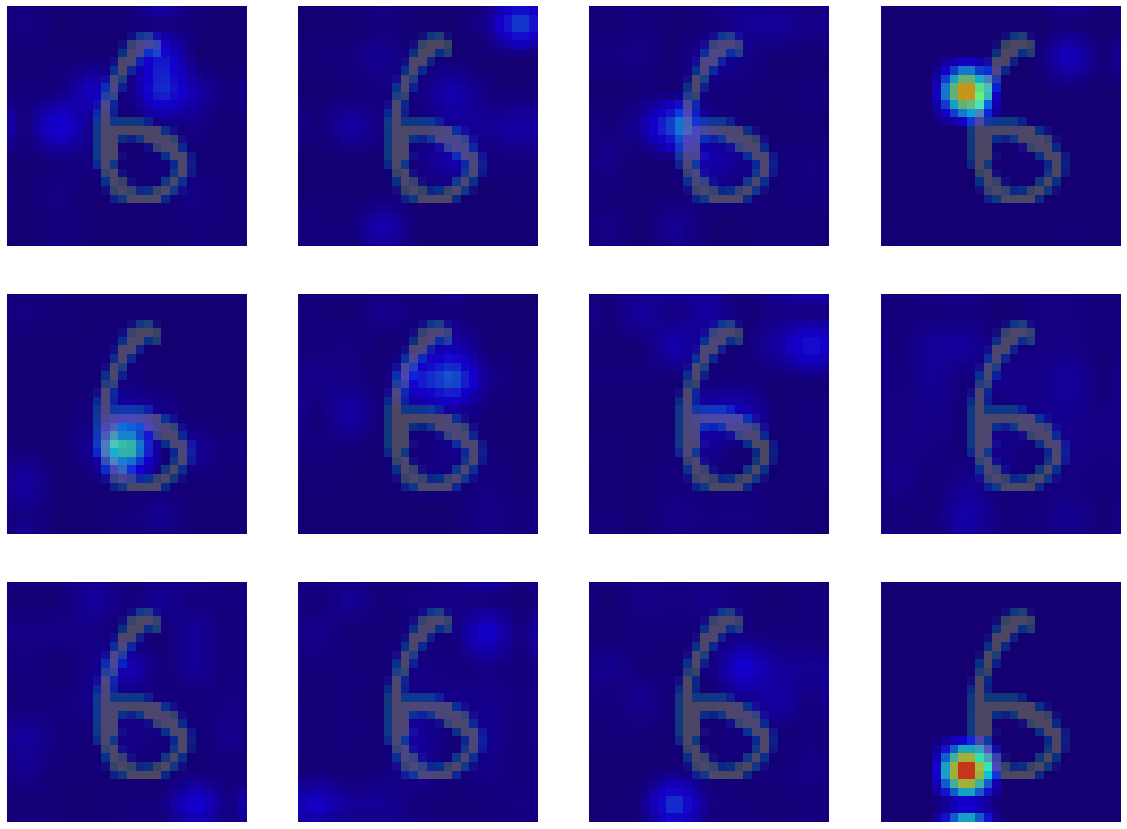

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i in range(12):
    ax[i//4, i%4].imshow(image)
    ax[i//4, i%4].imshow(maps[i], alpha=0.7, cmap='jet', vmin = 0, vmax = 0.9)
    ax[i//4, i%4].axis('off')